In [10]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import chisquare

from sklearn.metrics import PredictionErrorDisplay

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'iframe'
#pio.renderers.default = "notebook_connected"  # o "notebook_connected" si estás usando Jupyter Notebook


from alfalfasimpy.fit import fitmodel

from sinfo import sinfo


sinfo()

-----
alfalfasimpy        NA
numpy               1.24.2
pandas              1.5.3
plotly              5.13.0
scipy               1.10.0
sinfo               0.3.1
sklearn             1.2.1
-----
IPython             8.10.0
jupyter_client      8.0.2
jupyter_core        5.2.0
-----
Python 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]
Linux-6.6.41-1-MANJARO-x86_64-with-glibc2.39
16 logical CPU cores
-----
Session information updated at 2024-08-13 19:12


## Ciclos de crecimiento normalizados

### Dataset 
- Columna gdd acumulado nomralizado común a todas las curvas de crecimiento normalizadas
- mean tengo el promedio de todas las curvas
- RMSD root mean square desviation

In [2]:
#cols = [f"c{i}" for i in range(1,13)] + ["mean", "RMSD"]

curvas = pd.read_csv("data/analisis_alfalfa/cycles_all.dat", sep=";")
curvas.head()

tau  ciclo_a2  ciclo_a5  ciclo_a6  ciclo_a7  ciclo_a8  ciclo_b1  \
0  0.000   0.08368   0.18706   0.30749   0.05260   0.34916   0.16852   
1  0.025   0.12953   0.08763   0.34628   0.21379   0.29988   0.18610   
2  0.050   0.17098   0.03246   0.37614   0.25630   0.27057   0.19487   
3  0.075   0.20778   0.14464   0.36757   0.29937   0.25198   0.21350   
4  0.100   0.24753   0.17777   0.37192   0.30343   0.27563   0.22031   

   ciclo_b3  ciclo_b4  ciclo_b5  ciclo_b6  ciclo_b7  ciclo_b8  mean_val  \
0   0.27118   0.08369   0.29095   0.13081   0.25767   0.12464  0.192287   
1   0.26174   0.10273   0.29575   0.15733   0.23871   0.12954  0.204084   
2   0.25435   0.11379   0.30898   0.16531   0.22313   0.13855  0.208786   
3   0.24226   0.12341   0.33622   0.17093   0.24315   0.14899  0.229150   
4   0.23840   0.13273   0.35841   0.18315   0.27509   0.16420  0.245714   

     deviat  
0  0.095814  
1  0.081586  
2  0.088959  
3  0.073758  
4  0.072088

In [3]:
curvas.columns.values[1:13]

array(['ciclo_a2', 'ciclo_a5', 'ciclo_a6', 'ciclo_a7', 'ciclo_a8',
       'ciclo_b1', 'ciclo_b3', 'ciclo_b4', 'ciclo_b5', 'ciclo_b6',
       'ciclo_b7', 'ciclo_b8'], dtype=object)

In [4]:
fig = go.Figure()
for una_curva in curvas.columns.values[1:13]:
    fig.add_trace(go.Scatter(x=curvas.tau, y=curvas[una_curva], name=una_curva))
fig.update_layout(width=530, height=425)
fig.show()

In [5]:
fig = go.Figure()
for una_curva in curvas.columns.values[1:13]:
    fig.add_trace(go.Scatter(x=curvas.tau, y=curvas[una_curva], name=una_curva, showlegend=False,
    marker=dict(color='lightgrey', opacity=1, size=10, line=dict(color='MediumPurple', width=1.5))))
fig.add_trace(go.Scatter(x = curvas.tau, y = curvas.mean_val, mode="markers+lines", name="Curva promedio",line=dict(color='red', width=1.5)))

fig.update_traces(line={'width': 3})
fig.update_layout(width=600, height=600, legend=dict(yanchor="top", y=.86, xanchor="left", x=0.1), template="plotly_white")
fig.update_layout(yaxis_title="Altura*", xaxis_title=r"$\tau$")
fig.update_layout(font=dict(size=16,  color='black'))

### Ajustes
Ajusto tanh y landau al promedio de las curvas

In [6]:
# calculo promedio y Std para chequear con Carlos, da ok
# curvas["prom"] = curvas.iloc[:,1:13].mean(axis=1)
# curvas["std"] = curvas.iloc[:,1:13].std(axis=1, ddof=0) # ddof=0 can be set to normalize by N instead of N-1
curvas

tau  ciclo_a2  ciclo_a5  ciclo_a6  ciclo_a7  ciclo_a8  ciclo_b1  \
0   0.000   0.08368   0.18706   0.30749   0.05260   0.34916   0.16852   
1   0.025   0.12953   0.08763   0.34628   0.21379   0.29988   0.18610   
2   0.050   0.17098   0.03246   0.37614   0.25630   0.27057   0.19487   
3   0.075   0.20778   0.14464   0.36757   0.29937   0.25198   0.21350   
4   0.100   0.24753   0.17777   0.37192   0.30343   0.27563   0.22031   
5   0.125   0.28500   0.05421   0.35922   0.23604   0.26749   0.23699   
6   0.150   0.32577   0.11736   0.32686   0.20149   0.24218   0.25469   
7   0.175   0.35148   0.09748   0.34235   0.19723   0.28838   0.26690   
8   0.200   0.37644   0.02942   0.34581   0.26284   0.35791   0.31836   
9   0.225   0.40630   0.05053   0.37491   0.33069   0.31867   0.36452   
10  0.250   0.43217   0.13622   0.35039   0.35430   0.23370   0.40661   
11  0.275   0.46398   0.26137   0.33988   0.36156   0.23457   0.44693   
12  0.300   0.48527   0.21204   0.34562   0.39580   0.28846   0.50423   
13  0.325   0.50600   0.19635   0.33897   0.44846   0.36954   0.54144   
14  0.350   0.51720   0.27202   0.34637   0.47097   0.41420   0.56616   
15  0.375   0.53434   0.37825   0.37309   0.48706   0.45148   0.59740   
16  0.400   0.56847   0.37329   0.44008   0.49934   0.44637   0.65913   
17  0.425   0.59310   0.35772   0.49468   0.53940   0.45717   0.67714   
18  0.450   0.62085   0.46727   0.49452   0.56116   0.49198   0.68310   
19  0.475   0.63861   0.61645   0.51719   0.61713   0.52466   0.71481   
20  0.500   0.67357   0.61686   0.53813   0.65082   0.53403   0.73382   
21  0.525   0.69711   0.57614   0.57508   0.67816   0.53357   0.77384   
22  0.550   0.74642   0.55658   0.58089   0.67522   0.52423   0.81638   
23  0.575   0.78585   0.66115   0.58669   0.68974   0.50338   0.85077   
24  0.600   0.84287   0.73324   0.60741   0.72817   0.51139   0.86005   
25  0.625   0.87567   0.76010   0.66384   0.76845   0.56560   0.83146   
26  0.650   0.92427   0.77565   0.68385   0.77617   0.61331   0.80847   
27  0.675   0.95338   0.78653   0.64188   0.82777   0.67862   0.81618   
28  0.700   0.98324   0.75319   0.60979   0.88400   0.72932   0.82980   
29  0.725   0.99881   0.73145   0.66716   0.90957   0.76648   0.84260   
30  0.750   0.99903   0.72641   0.77480   0.85682   0.79563   0.83497   
31  0.775   0.98102   0.76515   0.87371   0.53362   0.83429   0.83174   
32  0.800   0.96250   0.84432   0.93383   0.54959   0.86304   0.83543   
33  0.825   0.92996   0.91194   0.98015   0.59996   0.84401   0.86680   
34  0.850   0.90461   0.99817   0.98220   0.64672   0.82608   0.87047   
35  0.875   0.87874   0.96149   0.95376   0.70296   0.83058   0.87568   
36  0.900   0.86327   0.91604   0.91968   0.82694   0.85676   0.89345   
37  0.925   0.84270   0.91601   0.90068   0.90707   0.91815   0.87545   
38  0.950   0.81553   0.91950   0.88675   0.93984   0.94185   0.90879   
39  0.975   0.78480   0.92878   0.87256   0.97822   0.97673   0.97625   
40  1.000   0.76470   0.93963   0.86763   0.99916   0.99883   0.99896   

    ciclo_b3  ciclo_b4  ciclo_b5  ciclo_b6  ciclo_b7  ciclo_b8  mean_val  \
0    0.27118   0.08369   0.29095   0.13081   0.25767   0.12464  0.192287   
1    0.26174   0.10273   0.29575   0.15733   0.23871   0.12954  0.204084   
2    0.25435   0.11379   0.30898   0.16531   0.22313   0.13855  0.208786   
3    0.24226   0.12341   0.33622   0.17093   0.24315   0.14899  0.229150   
4    0.23840   0.13273   0.35841   0.18315   0.27509   0.16420  0.245714   
5    0.24818   0.14624   0.36948   0.19981   0.28720   0.18162  0.239290   
6    0.26349   0.15471   0.38896   0.22658   0.29072   0.21035  0.250263   
7    0.27705   0.16744   0.41181   0.23528   0.30435   0.23552  0.264606   
8    0.30321   0.18709   0.45240   0.26384   0.30559   0.26350  0.288867   
9    0.32215   0.19545   0.47681   0.32864   0.32262   0.29678  0.315673   
10   0.34219   0.23157   0.51732   0.38852   0.40449   0.31794  0.342952   
11   0.34474   0.25901   0.

### Evaluación del modelo Fisher


#### Scatter plots

In [6]:
coef = {"ciclo_a6":[1.575,0.626],
        "ciclo_a7":[1.755,0.722],
        "ciclo_a5":[3.206,1.551],
        "ciclo_a8":[1.849,0.838],
        "ciclo_a2":[2.611,0.840],
        "ciclo_b1":[2.569,0.820],
        "ciclo_b3":[2.648,1.028],
        "ciclo_b4":[3.735,1.549],
        "ciclo_b5":[1.875,0.490],
        "ciclo_b6":[2.616,0.826],
        "ciclo_b7":[2.864,0.834],
        "ciclo_b8":[3.326,1.183]}
x = curvas.tau
modelos = {}
for un_ciclo in coef:
    c1, c2 = coef[un_ciclo]
    modelos[un_ciclo] = fitmodel.mytanh(x, c1, c2)

In [7]:
fig = go.Figure()
for una_curva in curvas.columns.values[1:13]:
    fig.add_trace(go.Scatter(x=modelos[una_curva], y=curvas[una_curva], mode="markers", name=una_curva, showlegend=False,
                            marker=dict(color='grey', opacity=0.6, size=10, line=dict(color='MediumPurple', width=1.5))))

fig.add_trace(go.Scatter(x=[0, 1], y=[0,1], mode="lines", name="1:1 Perfect Fit", line=dict(color='red', width=1.5)))

fig.update_layout(width=600, height=600, legend=dict(yanchor="top", y=.22, xanchor="left", x=0.57), template="plotly_white")
fig.update_layout(yaxis_title=r"$y\;(\tau)$", xaxis_title="Fisher model")
fig.update_layout(font=dict(size=18,  color='black'))
fig.show()

### Ajuste Fisher, Landau y Gompertz con curva promedio

#### Ajuste NO Linear Least Squares Fisher, landau, Gompertz 

In [8]:
# Ajuste NO LINEAL para ambos Fisher y Landau
x, y = curvas.tau.to_numpy(), curvas.mean_val.to_numpy(),

tanh_params, tcovariance = curve_fit(fitmodel.mytanh, x, y)
landau_params, tcovariance = curve_fit(fitmodel.landau, x, y)

Hu_tanh, n_tanh = tanh_params
Hu_landau, n_landau = landau_params

y_mytanh = fitmodel.mytanh(x, Hu_tanh, n_tanh)
y_landau = fitmodel.landau(x, Hu_landau, n_landau)

#### Ajuste Gompertz ordinary least square

$$y=e^{-\beta_1e^{-\beta_2x}}$$
$$log(y)=log(e^{-\beta_1e^{-\beta_2x}})$$
$$-log(y)=\beta_1e^{-\beta_2x}$$
$$log(1/y)=\beta_1e^{-\beta_2x}$$
$$log(log(1/y))=log(\beta_1e^{-\beta_2x})$$
$$log(log(1/y))=log(\beta_1)- \beta_2x$$
$$Y = \beta_{1\text{log}} - \beta_2x$$

In [9]:
# Ajuste LINEAL para Goempertz: 
# y= exp(-B1*exp(-B2*x)) = > log(log(y)) = log(-B1) - B2*x

#matriz de coeficientes

A =  np.ones((len(x),2))
A[:,1] = -x;
Y = np.log(np.log(1/y)) # log(1/y) = -log(y)
B = A.T@A
e = A.T@Y
coef = np.linalg.inv(B)@e

B1 = np.exp(coef[0])
B2 = coef[1]
y_gompertz = np.exp(-B1*np.exp(-B2*x))
print(f"Coeficientes: B1={B1}, B2={B2}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, name="y_mean"))
fig.add_trace(go.Scatter(x=x, y=y_gompertz, name="Gompertz"))
fig.show()

Coeficientes: B1=2.2560388524572836, B2=3.5285080544747816


In [16]:
# R2 Y RRMSE
#===========

#Fisher
R2_mytanh = np.corrcoef(y, y_mytanh)[0,1]**2
rrmse_mytanh = np.sqrt(np.mean((y - y_mytanh)**2))/(np.max(y) - np.min(y))

#Landau
R2_landau = np.corrcoef(y, y_landau)[0,1]**2
rrmse_landau = np.sqrt(np.mean((y - y_landau)**2))/(np.max(y) - np.min(y))

#Gompertz
R2_gompertz = np.corrcoef(y, y_gompertz)[0,1]**2
rrmse_gompertz = np.sqrt(np.mean((y - y_gompertz)**2))/(np.max(y) - np.min(y))

print(f"R2: tanh={R2_mytanh}, landau={R2_landau}, gompertz={R2_gompertz}", )
print(f"RMSE: tanh={rrmse_mytanh}, landau={rrmse_landau}, gompertz={rrmse_gompertz}")

print("Params:")
print(f"Tanh fit: Hu={Hu_tanh:.3f}, n={n_tanh:.3f}")
print(f"Landau fit: Hu={Hu_landau:.3f}, n={n_landau:.3f}")
print(f"Gompertz fit: Hu={B1:.3f}, n={B2:.3f}")

R2: tanh=0.9952867762492711, landau=0.9951086057086667, gompertz=0.9820390872402962
RMSE: tanh=0.02496139654509409, landau=0.026585082154547086, gompertz=0.04887656494425247
Params:
Tanh fit: Hu=2.356, n=0.867
Landau fit: Hu=3.054, n=1.713
Gompertz fit: Hu=2.256, n=3.529


In [17]:
yfish = fitmodel.mytanh(curvas.tau, 2.313, 0.849)
yland = fitmodel.landau(curvas.tau, 2.987, 1.688)
ygomp = fitmodel.gompertz(curvas.tau, np.exp(0.793874), 3.49977) # Gomper no lineal por Carlos

#### Plots

In [17]:
#error_estandar = curvas.deviat / np.sqrt(12)

# Calcula los límites de la banda de incertidumbre
limite_inferior = curvas.mean_val - curvas.deviat
limite_superior = curvas.mean_val + curvas.deviat

In [24]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x=curvas.tau, y=curvas.prom, error_y=dict(type="data", array=curvas["std"].to_numpy(), visible=True),mode="markers", name="Data average"))

fig.add_trace(go.Scatter(x=curvas.tau, y=limite_superior, fill='tonexty', fillcolor='rgba(220,176,242,0.03)', 
                         line=dict(color='rgba(255,255,255,0)'), hoverinfo="skip", showlegend=False))

fig.add_trace(go.Scatter(x=curvas.tau, y=limite_inferior, fill='tonexty', fillcolor='lightgray', 
                         line=dict(color='rgba(255,255,255,0)'), hoverinfo="skip", showlegend=True, name=r"$\pm \; \sigma$"))

fig.add_trace(go.Scatter(x=curvas.tau, y=curvas.mean_val, mode="markers", name=r"$y_{\text{mean}}$", opacity=1, marker=dict(color='gold',size=10, line=dict(color='gray', width=1.5))))

fig.add_trace(go.Scatter(x=curvas.tau, y=yfish, mode="lines", opacity=0.99, line=dict(color='Coral', width=3.5), name="Fisher       | rmsd = 2.5%"))
fig.add_trace(go.Scatter(x=curvas.tau, y=yland, mode="lines", opacity=0.99, line=dict(color='Dodgerblue', width=3.5), name="Landau     | rmsd = 2.7%"))
fig.add_trace(go.Scatter(x=curvas.tau, y=ygomp, mode="lines", opacity=0.99, line=dict(color='Limegreen', width=3.5), name="Gompertz | rmsd = 4.9%"))

# boxplots darkred, darksalmon, darkseagreen
#for i in range(0,41,5):
#    fig.add_trace(go.Box(x=[0.025*i ]*11, y=curvas.iloc[i,1:13].values, opacity=0.9, boxmean=True, marker_color='rgb(220,176,242)', boxpoints=False, showlegend=False))

fig.update_layout(width=630, height=630, legend=dict(yanchor="top", y=.33, xanchor="left", x=0.4), template="plotly_white")
fig.update_layout(yaxis_title=r"$y\;(\tau)$", xaxis_title=r"$\tau$")
fig.update_layout(font=dict(size=17,  color='black'))
fig.show()

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ygomp, y=curvas.mean_val, mode="markers", name="Gompertz | r² = 0.98",
                        marker=dict(color='Limegreen', opacity=0.9, size=10, line=dict(color='gray', width=1.5))))
fig.add_trace(go.Scatter(x=yland, y=curvas.mean_val, mode="markers", name="Landau     | r² = 0.99",
                        marker=dict(color='Dodgerblue', opacity=0.9, size=10, line=dict(color='gray', width=1.5))))
fig.add_trace(go.Scatter(x=yfish, y=curvas.mean_val, mode="markers", name="Fisher       | r² = 0.99",
                        marker=dict(color='Coral', opacity=0.9, size=10, line=dict(color='gray', width=1.5))))



fig.add_trace(go.Scatter(x=[0, 1], y=[0,1], mode="lines", name="1:1", line=dict(color='gray', width=1.5)))

fig.update_layout(width=630, height=630, legend=dict(yanchor="top", y=.33, xanchor="left", x=0.4), template="plotly_white")
fig.update_layout(yaxis_title=r"$y_{\text{mean}}$", xaxis_title="Growth models")
fig.update_layout(font=dict(size=17,  color='black'))
fig.show()

## Incertidumbre - Distribución de datos

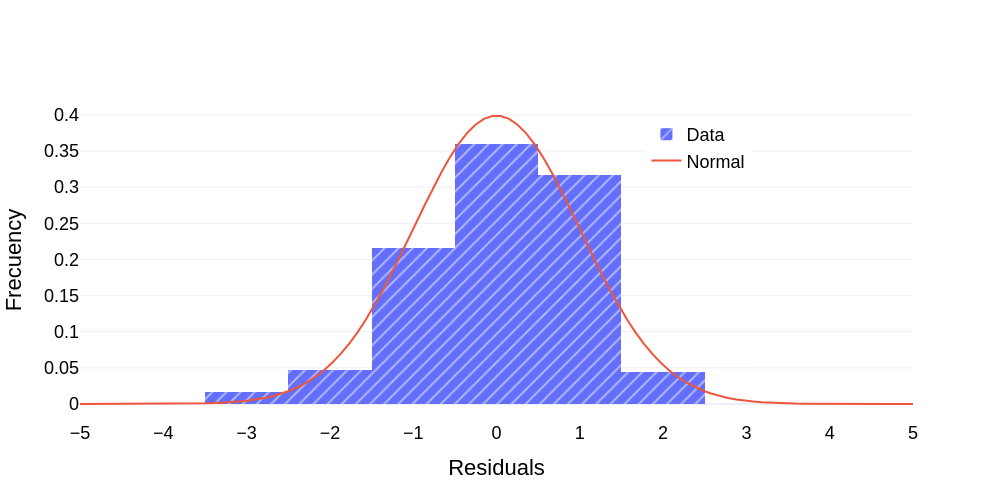

In [23]:

# SD promedio
sd_promedio = curvas["deviat"].sum()/41
res = (curvas["ciclo_a2"]-curvas["mean_val"])/(sd_promedio)
for curva in curvas.columns.values[2:13]:
    res = np.concatenate((res, (curvas[curva]-curvas["mean_val"])/(sd_promedio)))

fig = go.Figure()
fig.add_trace(go.Histogram(x=res, opacity=.99, marker_pattern_shape="/", histnorm='probability', name="Data", 
                           xbins=dict(start=-3.5, end=3.5, size=1)))

# Agregar la traza de la distribución normal
x_values = np.linspace(-5, 5, 100)
sd = 1;
y_values = 1 / (sd*np.sqrt(2 * np.pi)) * np.exp((-x_values ** 2)/(2*sd*sd))
fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Normal'))


# Configurar diseño y etiquetas
fig.update_layout(
    template="plotly_white",
    xaxis=dict(title='Residuals'),
    yaxis=dict(title='Frecuency'), width=620, height=500,
)
fig.update_layout(barmode='overlay')
fig.update_layout(font=dict(size=18,  color='black'), legend=dict(yanchor="top", y=.95, xanchor="left", x=0.68))
#fig.update_traces(marker=dict(pattern_fillmode="replace"))
fig.update_xaxes(tick0=0, dtick=1)
fig.show()

### Gráfico de barras

In [3]:
#datos = pd.read_csv("data/analisis_alfalfa/histo_carlos/bucket4.dat", sep=",")
datos = pd.read_csv("data/analisis_alfalfa/nuevo_histo_carlos/bucket.dat", sep=",")
datos

x    k  y_mean  Fisher  Landau  Gompertz   y1   y2   y3   y4
0 -2.75  0.5  0.0102  0.0142  0.0163    0.0163    5    7    8    8
1 -2.00  1.0  0.0691  0.0711  0.0671    0.0976   34   35   33   48
2 -1.00  1.0  0.1972  0.2114  0.2256    0.1890   97  104  111   93
3  0.00  1.0  0.3638  0.3557  0.3659    0.3679  179  175  180  181
4  1.00  1.0  0.3130  0.2967  0.2683    0.2825  154  146  132  139
5  2.00  1.0  0.0447  0.0508  0.0528    0.0386   22   25   26   19
6  2.75  0.5  0.0000  0.0000  0.0000    0.0061    0    0    0    3

In [22]:
x = np.linspace(-4,4,100)
y_gauss = np.exp(-x*x/2)/(np.sqrt(2*np.pi))

mediacolor = "gold"
fig = go.Figure()
fig.add_trace(go.Bar(x=datos.x[1:-1], y=datos.y_mean[1:-1], width=1, name=r"$y_{\text{mean}}$", marker_color = mediacolor, opacity=0.75))
fig.add_trace(go.Bar(x=datos.x[1:-1], y=datos.Fisher[1:-1], width=1, name="Fisher", opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='/', fgcolor="blue"))))
fig.add_trace(go.Bar(x=datos.x[1:-1], y=datos.Landau[1:-1], width=1, name="Landau", opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='.', fgcolor="green"))))
fig.add_trace(go.Bar(x=datos.x[1:-1], y=datos.Gompertz[1:-1], width=1, name="Gompertz", opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='+', fgcolor="violet"))))

fig.add_trace(go.Bar(x=datos.x[0:1], y=datos.y_mean[0:1], width=0.5, name="y_mean", marker_color = mediacolor, showlegend=False))
fig.add_trace(go.Bar(x=datos.x[0:1], y=datos.Fisher[0:1], width=0.5, name="Fisher", showlegend=False, opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='/', fgcolor="blue"))))
fig.add_trace(go.Bar(x=datos.x[0:1], y=datos.Landau[0:1], width=0.5, name="Landau", showlegend=False, opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='.', fgcolor="green"))))
fig.add_trace(go.Bar(x=datos.x[0:1], y=datos.Gompertz[0:1], width=0.5, name="Gompertz", showlegend=False,opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='+', fgcolor="violet"))))

fig.add_trace(go.Bar(x=datos.x[-1:], y=datos.Gompertz[-1:], width=0.5, name="Gompertz", showlegend=False, opacity=1, marker=dict(color='rgba(0,0,0,0)', pattern=dict(shape='+',fgcolor="violet"))))

fig.add_trace(go.Scatter(x=x, y=y_gauss, mode="lines", name="Gauss", line=dict(color='blueviolet', width=3)))

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.0)
fig.update_yaxes(range=[0,0.5])

fig.update_layout(yaxis_title="Relative Frecuency", xaxis_title="Normalized Residual", barmode='overlay', template="plotly_white", 
                  width=750, height=650, legend=dict(font=dict(size=18), yanchor="top", y=0.95, xanchor="left", x=0.75, orientation='v'))
fig.update_layout(font=dict(size=17,  color='black'))

fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        showticklabels=True,
        ticks='outside',  # Esto añade las rayitas verticales
        ticklen=6,        # Longitud de las rayitas
        tickwidth=2,      # Ancho de las rayitas
        tickcolor='black' # Color de las rayitas
    )
)


In [ ]:
aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

## GDDs por ciclo
- Ciclo 1a: Nov-Dic 20
- Ciclo 2a: Dic-Jan 21
- Ciclo 5a: Nov-Dic 21
- Ciclo 6a: Sep-Oct 21
- Ciclo 7a: Oct-Nov 21
- Ciclo 8a: Nov-Dic 21

- Ciclo 1b: Nov-Dic 22
- Ciclo 3b: Mar-Apr 23
- Ciclo 4b: Apr-Jun 23
- Ciclo 5b: Oct-Dic 23
- Ciclo 6b: Dic-Jan 24
- Ciclo 7b: Jan-Feb 24
- Ciclo 8b: Feb-Mar 24

In [4]:
path = "data/analisis_alfalfa/" 
# está excluído ciclo1a_modelado.csv porque hay algo fulero
files = "ciclo2a_modelado.csv ciclo5a_modelado.csv ciclo6a_modelado.csv ciclo7a_modelado.csv ciclo8a_modelado.csv "
files += "ciclo1_modelado.csv ciclo3_modelado.csv ciclo4_modelado.csv ciclo5_modelado.csv ciclo6_modelado.csv ciclo7_modelado.csv ciclo8_modelado.csv"

dates = "Dic-Jan 21,Nov-Dic 21,Sep-Oct 21,Oct-Nov 21,Nov-Dic 21,Nov-Dic 22,Mar-Apr 23,Apr-Jun 23,Oct-Dic 23,Dic-Jan 24,Jan-Feb 24,Feb-Mar 24".split(",")
         

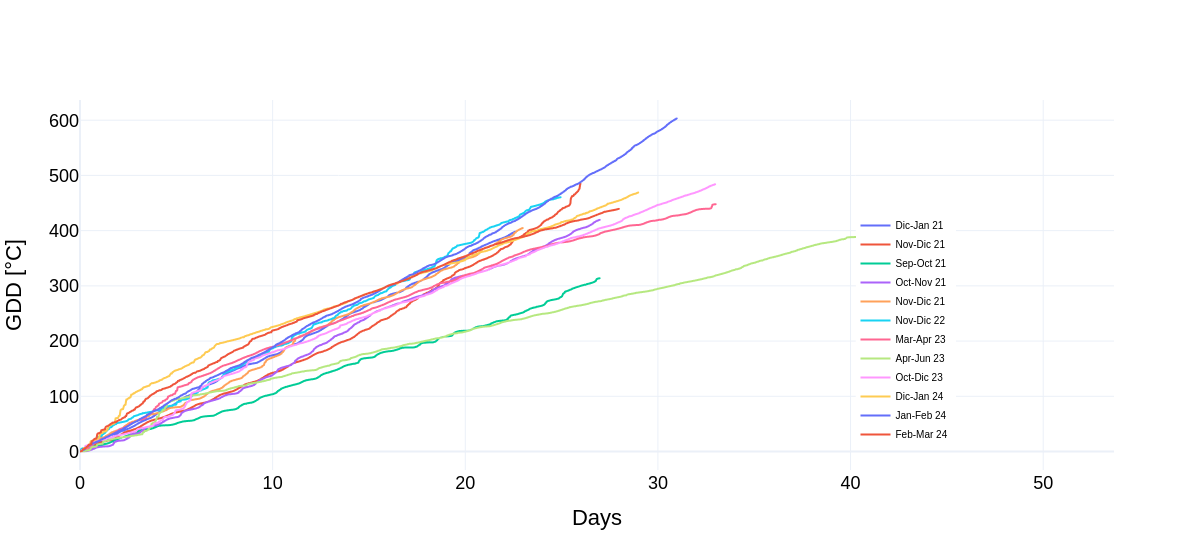

In [17]:
fig = go.Figure()

for date, file in zip(dates,files.split()):
    df = pd.read_csv(path+file)
    day = df["days (gdd_denorm/gdd_mean)"]
    gdd = df["gdd"]
    fig.add_trace(go.Scattergl(x=day, y=gdd, mode="lines", name=date))
fig.update_layout(template="plotly_white", xaxis_title="Days", yaxis_title="GDD [°C]")
fig.update_layout(width=510, height=550, legend=dict(yanchor="top", y=0.7, xanchor="left", x=0.75, orientation='v'))
fig.update_layout(font=dict(size=18,  color='black'))
fig.update_xaxes(range=[0,55])

fig.update_layout(
    legend=dict(
        font=dict(
            size=10  # Tamaño de texto para las leyendas
        )
    )
)
fig.show()

## Test ecuaciones paper
- Me fijo que den igual las ecuaciones puestas en el paper

\begin{equation}
 y(\tau,\mathbf{c})= \left\{ \begin{aligned} 
  &\frac{1}{2} + \frac{1}{2}tanh(\mathbf{\text{c}_1}\tau - \mathbf{\text{c}_2})    \quad\quad\quad: \text{ Fisher} \\
  &\sqrt{ \frac{1}{2} + \frac{1}{2}tanh(\mathbf{\text{c}_1}\tau - \mathbf{\text{c}_2}) }  \quad\quad: \text{ Landau,} \\
  &\frac{1-tanh[exp(\mathbf{\text{c}_2} - \mathbf{\text{c}_1}\tau)/2]}{1+tanh[exp(\mathbf{\text{c}_2} - \mathbf{\text{c}_1}\tau)/2]}    \quad: \text{ Gompertz}\;, \\
\end{aligned} \right. \label{e4}
\end{equation}

In [20]:
tau = curvas.tau

c1 = np.array([2.313, 2.987, 3.500])
c2 = np.array([0.849, 1.688, 0.794])

yy_fisher = 0.5+0.5*np.tanh(c1[0]*tau - c2[0])
yy_landau = np.sqrt(0.5 + 0.5*np.tanh(c1[1]*tau - c2[1]))
yy_gomper = (1-np.tanh(np.exp(c2[2]-c1[2]*tau)/2)) / (1 + np.tanh(np.exp(c2[2]-c1[2]*tau)/2)) 


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tau, y=curvas["mean_val"], mode="markers", name="y_mean"))
fig.add_trace(go.Scatter(x=tau, y=yy_fisher, name="fisher"))
fig.add_trace(go.Scatter(x=tau, y=yy_landau, name="landau"))
fig.add_trace(go.Scatter(x=tau, y=yy_gomper, name="gomper"))

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tau, y=curvas["mean_val"], mode="markers", name="y_mean"))
fig.add_trace(go.Scatter(x=tau, y=yfish, name="fisher1"))
fig.add_trace(go.Scatter(x=tau, y=yland, name="landau1"))
fig.add_trace(go.Scatter(x=tau, y=ygomp, name="gomper1"))

fig.add_trace(go.Scatter(x=tau, y=yy_fisher, name="fisher2"))
fig.add_trace(go.Scatter(x=tau, y=yy_landau, name="landau2"))
fig.add_trace(go.Scatter(x=tau, y=yy_gomper, name="gomper2"))

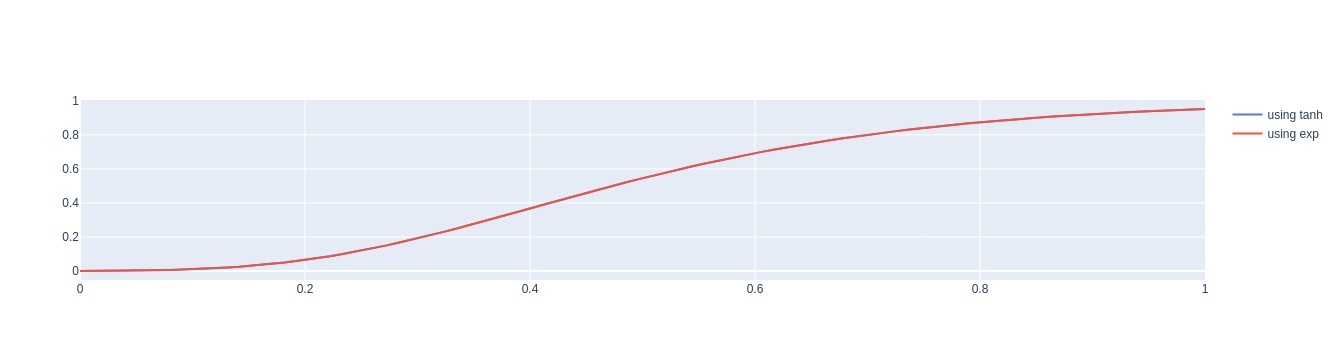

In [15]:
t = np.linspace(0,1,100)

c, k = 2,5 

# Gompertz
y1 = (2/ (1 + np.tanh(0.5*np.exp(c-k*t))))-1
y2 = np.exp(-np.exp(c-k*t))

fig = go.Figure()

fig.add_trace(go.Scatter(x=t, y=y1, name="using tanh"))
fig.add_trace(go.Scatter(x=t, y=y2, name="using exp"))


## Coeficiente malthusiano



$\mathbf{\text{c}_1}= \frac{r\;G_\text{DD\text{M}}}{\alpha},\quad \text{Fisher}$

$\mathbf{\text{c}_1}= \frac{Q^2\; G_\text{DD\text{M}}}{\alpha},\quad \text{Landau}$


In [6]:
import numpy as np

c1_fisher = 2.313 
c1_landau = 2.987

# valores promedios
alpha_prom = 15.15  # ºC
gdd_max_prom = np.array([314, 420, 485, 405, 409, 462, 448, 409, 484, 571, 603, 440]).mean()

# parámetro malthusiano
r_fisher = c1_fisher*alpha_prom/gdd_max_prom
r_landau = c1_landau*alpha_prom/gdd_max_prom

print(f"r_fisher = {r_fisher}")
print(f"r_landau = {r_landau}")

r_fisher = 0.0771565871559633
r_landau = 0.09963974311926606


In [8]:
# boxplot con todos los parámetros malthusianos
c1_fisher_curvas =  np.array([1.575, 1.755, 3.206, 1.849, 2.611, 2.569, 2.648, 3.735, 1.875, 2.616, 2.864, 3.326])
gdd_max_curvas = np.array([314, 420, 485, 405, 409, 462, 448, 409, 484, 571, 603, 440])

# para hacer un boxplot tengo que verl el alpha de cada ciclo
# uso el promedio por vago
malthus_r = c1_fisher_curvas*alpha_prom/gdd_max_curvas

In [19]:
fig = go.Figure()
fig.add_trace(go.Box(y=malthus_r, name="Malthus parameter", jitter=0.5, pointpos=0,
    boxpoints='all', # represent all points
    marker_color='rgb(7,40,89)',
    line_color='rgb(7,40,89)'
))
